In [28]:
import glob
import os
from typing import List, Sequence, Dict
from collections import namedtuple

import datetime

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

import boa.acquisition.util as util
from boa.optimization.data import FileHandler, Data

from pygmo import hypervolume

save_folder = "../plots/notebook_plots/bayesopt_analysis/"

DataTuple = namedtuple('DataTuple', field_names=['df', 'input_labels', 'output_labels'])

sns.set_style('whitegrid')

In [2]:
input_labels = {
    "fft": [
            # NB: cache_bandwith is missing!
            'cycle_time',
            'pipelining',
            'cache_size',
            'cache_assoc',
            'cache_hit_latency',
            'cache_line_sz',
            'cache_queue_size',
            'tlb_hit_latency',
            'tlb_miss_latency',
            'tlb_page_size',
            'tlb_entries',
            'tlb_max_outstanding_walks',
            'tlb_assoc',
            'tlb_bandwidth',
            'l2cache_size',
            'enable_l2',
            'pipelined_dma',
            'ignore_cache_flush',
        ],
    "stencil3d": [
            'cycle_time',
            'cache_size',
            'cache_assoc',
            'cache_hit_latency',
            'tlb_hit_latency',
            'tlb_entries',
            'l2cache_size',
        ],
    "stencil3d_v2": [
            "cycle_time",
            "pipelining",
            "cache_size",
            "cache_assoc",
            "cache_hit_latency",
            "cache_line_sz",
            "cache_queue_size",
            "tlb_hit_latency",
            "tlb_miss_latency",
            "tlb_entries",
            "tlb_max_outstanding_walks",
            "tlb_assoc",
            "tlb_bandwidth",
            "l2cache_size",
            "pipelined_dma",
            "ignore_cache_flush",
        ],
    "gemm": [
        'cycle_time',
        'cache_size',
        'cache_assoc',
        'cache_hit_latency',
        'tlb_hit_latency',
        'tlb_entries',
        'l2cache_size',
    ],
    "gemm_v2":  [
            "cycle_time",
            "pipelining",
            "cache_size",
            "cache_assoc",
            "cache_hit_latency",
            "cache_line_sz",
            "cache_queue_size",
            "tlb_hit_latency",
            "tlb_miss_latency",
            "tlb_entries",
            "tlb_max_outstanding_walks",
            "tlb_assoc",
            "tlb_bandwidth",
            "l2cache_size",
            "pipelined_dma",
            "ignore_cache_flush",
        ],
    "smaug": [
        "num_threads",
        "l2_assoc",
        "accel_clock_time",
        "dma",
        "acp",
        "num_accels",
        "l2_size",
    ]
}

output_labels = {
    "fft": [
            'cycle',
            'avg_power',
            'idle_fu_cycles',
            'avg_fu_power',
            'avg_fu_dynamic_power',
            'avg_fu_leakage_power',
            'avg_mem_power',
            'avg_mem_dynamic_power',
            'avg_mem_leakage_power',
            'total_area',
            'fu_area',
            'mem_area',
            'num_double_precision_fp_multipliers',
            'num_double_precision_fp_adders',
            # 'num_trigonometric_units',
            # 'num_bit-wise_operators_32',
            # 'num_shifters_32',
            'num_registers_32',
        ],
    "stencil3d": [
            'cycle',
            'avg_power',
            'fu_power',
            'avg_fu_dynamic_power',
            'avg_fu_leakage_power',
            'avg_mem_power',
            'avg_mem_dynamic_power',
            'avg_mem_leakage_power',
            'total_area',
            'fu_area',
            'mem_area',
            # 'num_sp_multiplier',
            # 'num_sp_adder',
            # 'num_dp_multiplier',
            # 'num_dp_adder',
            # 'num_trig_unit',
            # 'num_multiplier',
            # 'num_adder',
            # 'num_bit_wise',
            # 'num_shifter',
            'num_register',
        ],
    "stencil3d_v2": [
            'cycle',
            'avg_power',
            'fu_power',
            'avg_fu_dynamic_power',
            'avg_fu_leakage_power',
            'avg_mem_power',
            'avg_mem_dynamic_power',
            'avg_mem_leakage_power',
            'total_area',
            'fu_area',
            'mem_area',
#             'num_sp_multiplier',
#             'num_sp_adder',
#             'num_dp_multiplier',
#             'num_dp_adder',
#             'num_trig_unit',
#             'num_multiplier',
#             'num_adder',
#             'num_bit_wise',
#             'num_shifter',
            'num_register',
        ],
    "gemm": [
        'cycle',
            'avg_power',
            'fu_power',
            'avg_fu_dynamic_power',
            'avg_fu_leakage_power',
            'avg_mem_power',
            'avg_mem_dynamic_power',
            'avg_mem_leakage_power',
            'total_area',
            'fu_area',
            'mem_area',
            # 'num_sp_multiplier',
            # 'num_sp_adder',
            # 'num_dp_multiplier',
            # 'num_dp_adder',
            # 'num_trig_unit',
            # 'num_multiplier',
            # 'num_adder',
            # 'num_bit_wise',
            # 'num_shifter',
            'num_register',
    ],
    "gemm_v2": [
            'cycle',
            'avg_power',
            'fu_power',
            'avg_fu_dynamic_power',
            'avg_fu_leakage_power',
            'avg_mem_power',
            'avg_mem_dynamic_power',
            'avg_mem_leakage_power',
            'total_area',
            'fu_area',
            'mem_area',
#             'num_sp_multiplier',
#             'num_sp_adder',
#             'num_dp_multiplier',
#             'num_dp_adder',
#             'num_trig_unit',
#             'num_multiplier',
#             'num_adder',
#             'num_bit_wise',
#             'num_shifter',
            'num_register',
        ],
    "smaug": [
        "total_time",
        "total_accel_time",
        "total_energy",
        "fu_energy",
        "spad_energy",
        "llc_leakage_energy",
        "llc_dynamic_energy",
        "total_area",
        "fu_area",
        "mem_area",
        # "num_sp_multiplier",
        # "num_sp_adder",
        # "num_dp_multiplier",
        # "num_dp_adder",
        # "num_trig_unit",
        "num_multiplier",
        "num_adder",
        "num_bit_wise",
        "num_shifter",
        "num_register"
    ]
}

separators = {
    "fft": " ",
    "stencil3d": "\t",
    "gemm": "\t",
    "stencil3d_v2": ",",
    "gemm_v2": ",",
    "smaug": ",",
}

objective_labels = {
    "fft": ['cycle', 'avg_power', 'total_area'],
    "stencil3d": ['cycle', 'avg_power', 'total_area'],
    "gemm": ['cycle', 'avg_power', 'total_area'],
    "stencil3d_v2": ['cycle', 'avg_power', 'total_area'],
    "gemm_v2": ['cycle', 'avg_power', 'total_area'],
    "smaug": ["total_energy", "total_time", "total_area"],
}

In [3]:
def load_dataset(dataset_path, separator, input_labels, output_labels) -> DataTuple:
    with open(dataset_path) as f:
        df = pd.read_csv(f, sep=separator, dtype=np.float64)

    return DataTuple(df=df[input_labels + output_labels],
                     input_labels=input_labels,
                     output_labels=output_labels)

def load_runs(directory: str) -> List[Data]:
    data_points = []
    for path in glob.glob(os.path.join(directory, '*.json')):
        handler = FileHandler(path=path)
        data_points.append(handler.load())
    return data_points


def calculate_volumes(dfs: Sequence[pd.DataFrame], min_max: pd.DataFrame, kind, final_only=False) -> List[pd.DataFrame]:
    normed_reference = np.array([1, 1, 1])

    volumes_list = []
    for df in dfs:
        points = df[objective_labels[kind]]
        normed_points = (points - min_max['min']) / (min_max['max'] - min_max['min'])
        
        if final_only:
            size = normed_points.shape[0]
            print(f"Calculating final hypervolume for {size} points!")
            
            volumes = [(size,
                        hypervolume(points=normed_points.values[:size]).compute(normed_reference))]
        else:
            volumes = [(size, hypervolume(points=normed_points.values[:size]).compute(normed_reference))
                       for size in range(10, normed_points.shape[0])]
        volumes_list.append(pd.DataFrame(volumes, columns=['size', 'volume']))

    return volumes_list


def summarize(volumes_list):
    frames = pd.concat([d.set_index('size') for d in volumes_list], axis=1)
    return frames.apply(lambda row: pd.Series({'mean': np.mean(row), 'std': np.std(row)}), axis=1).reset_index()

In [4]:
def calculate_statistics(experiment_directories, dataset_path, kind):

    experiment_dict = {}

    # Load experiment JSON files
    for model_name, directory in experiment_directories:
        experiments = load_runs(directory)

        dfs = [pd.DataFrame(data=np.hstack((experiment.input, experiment.output)), 
                            columns=experiment.input_labels + experiment.output_labels)

               for experiment in experiments]

        base_name = os.path.basename(directory)
        experiment_dict[model_name] = dfs

    # Load the dataset
    dataset = load_dataset(dataset_path=dataset_path, 
                           separator=separators[kind], 
                           input_labels=input_labels[kind],
                           output_labels=output_labels[kind])
    min_max = dataset.df[objective_labels[kind]].apply(lambda column: pd.Series({
        'min': column.min(),
        'max': column.max()
    })).transpose()

    # Calculate summary statistics for the dataset
    volumes_dict = {key: calculate_volumes(experiment, min_max, kind) for key, experiment in experiment_dict.items()}
    summary_dict = {key: summarize(volume) for key, volume in volumes_dict.items()}
    
    dataset_stats = calculate_dataset_statistics(dataset_path, kind)
    
    return experiment_dict, volumes_dict, summary_dict, dataset_stats

In [5]:
def calculate_dataset_statistics(dataset_path, kind):
    dataset = load_dataset(dataset_path=dataset_path, 
                           separator=separators[kind], 
                           input_labels=input_labels[kind],
                           output_labels=output_labels[kind])
    min_max = dataset.df[objective_labels[kind]].apply(lambda column: pd.Series({
        'min': column.min(),
        'max': column.max()
    })).transpose()
    
    return calculate_volumes([dataset.df], min_max, kind, final_only=True)

In [46]:
def plot_bayesopt_experiment(experiment_dict, volumes_dict, summary_dict, dataset_stats, kind, save=True):
    
    
    label_dict = {
        'random': 'SGS',
        'ff-gp': 'FF-GP',
        'gp': 'FF-GP',
        'gpar': 'GPAR',
        'mf-gpar': 'MF-GPAR',
        'mf-gpar_3': 'MF-GPAR-3',
        'mf-gpar_5': 'MF-GPAR-5',
    }

    color_dict = {
        'random': 'C0',
        'gp': 'C1',
        'ff-gp': 'C2',
        'gpar': 'C1',
        'mf-gpar': 'C3',
        'mf-gpar_3': 'C4',
        'mf-gpar_5': 'C5',
    }

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

    for name, volumes_list in volumes_dict.items():
        for volumes in volumes_list:
            ax.plot(
                volumes['size'],
                volumes['volume'],
                color=color_dict[name],
                alpha=0.3,
                linestyle='dashed',
                zorder=-1,
                label='_nolegend_',
            )

    for name, summary in summary_dict.items():
        ax.fill_between(
            x=summary['size'],
            y1=summary['mean'] + 2 * summary['std'],
            y2=summary['mean'] - 2 * summary['std'],
            color=color_dict[name],
            alpha=0.2,
            zorder=-2,
        )

    ordered_names = ['random', 'ff-gp', 'gpar', 'mf-gpar', 'mf-gpar_3', 'mf-gpar_5']

    for name in ordered_names:
        if name not in summary_dict:
            continue

        ax.plot(summary_dict[name]['size'],
                summary_dict[name]['mean'],
                label=label_dict[name],
                linestyle='solid',
                linewidth=3,
                color=color_dict[name],
                zorder=0)

    ax.axhline(dataset_stats[0]["volume"].values[0], 
               linestyle='--', c='k', linewidth=2, 
               label='Maximum Achievable Hypervolume')
    ax.legend(loc='lower right', prop={'size': 24})
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.set_ylabel('Hypervolume', fontsize=24)
    ax.set_xlabel('Evaluations', fontsize=24)
    
    ax.set_xlim([10, 129])

    
    fig.tight_layout()
    fig.show()
    if save:
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        fig.savefig(f'{save_folder}/{kind}/bayesopt-{current_time}.pdf')
        print("Saved figure!")
    else:
        print("Figure wasn't saved.")

In [37]:
def comparison_plot(old_experiment_dict,                  
                    old_volumes_dict, 
                    old_summaries_dict, 
                    old_dataset_stats,
                    
                    new_experiment_dict,
                    new_volumes_dict, 
                    new_summaries_dict, 
                    new_dataset_stats,
                    
                    kind):
    
    names_map = {
        'random': 0,
        'gp': 1,
        'ff-gp': 1,
        'gpar': 2,
        'mf-gpar': 3,
        'mf-gpar_3': 3,
        'mf-gpar_5': 3,
    }
    
    label_dict = {
        'random': 'Random',
        'gp': 'FF-GP',
        'ff-gp': 'FF-GP',
        'gpar': 'GPAR',
        'mf-gpar': 'MF-GPAR',
        'mf-gpar_3': 'MF-GPAR-3',
        'mf-gpar_5': 'MF-GPAR-5',
    }

    old_color_dict = {
        'random': 'C0',
        'gp': 'C1',
        'ff-gp': 'C1',
        'gpar': 'C2',
        'mf-gpar': 'C3',
        'mf-gpar_3': 'C4',
        'mf-gpar_5': 'C5',
    }

    new_color_dict = {
        'random': 'C1',
        'ff-gp': 'C2',
        'gpar': 'C3',
        'mf-gpar': 'C4',
        'mf-gpar_3': 'C5',
        'mf-gpar_5': 'C0',
    }
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    
    axes = axes.flatten()
    
    for name, index in names_map.items():
        if name in old_volumes_dict:
            for volumes in old_volumes_dict[name]:
                axes[index].plot(
                    volumes['size'],
                    volumes['volume'],
                    color=old_color_dict[name],
                    alpha=0.3,
                    linestyle='dashed',
                    zorder=-1,
                    label='_nolegend_',
                )
                
            axes[index].fill_between(
                x=old_summaries_dict[name]['size'],
                y1=old_summaries_dict[name]['mean'] + 2 * old_summaries_dict[name]['std'],
                y2=old_summaries_dict[name]['mean'] - 2 * old_summaries_dict[name]['std'],
                color=old_color_dict[name],
                alpha=0.2,
                zorder=-2,
            )
            
            axes[index].plot(old_summaries_dict[name]['size'],
                old_summaries_dict[name]['mean'],
                label=f"Old {label_dict[name]}",
                linestyle='solid',
                linewidth=3,
                color=old_color_dict[name],
                zorder=0)
                
        if name in new_volumes_dict:    
            for volumes in new_volumes_dict[name]:
                axes[index].plot(
                    volumes['size'],
                    volumes['volume'],
                    color=new_color_dict[name],
                    alpha=0.3,
                    linestyle='dashed',
                    zorder=-1,
                    label='_nolegend_',
                )
                
            axes[index].fill_between(
                x=new_summaries_dict[name]['size'],
                y1=new_summaries_dict[name]['mean'] + 2 * new_summaries_dict[name]['std'],
                y2=new_summaries_dict[name]['mean'] - 2 * new_summaries_dict[name]['std'],
                color=new_color_dict[name],
                alpha=0.2,
                zorder=-2,
            )
            
            axes[index].plot(new_summaries_dict[name]['size'],
                new_summaries_dict[name]['mean'],
                label=f"New {label_dict[name]}",
                linestyle='solid',
                linewidth=3,
                color=new_color_dict[name],
                zorder=0)
            
        axes[index].set_title(label_dict[name])

        axes[index].set_ylabel('Hypervolume', fontsize=12)
        axes[index].set_xlabel('Evaluations', fontsize=12)

        axes[index].set_xlim([10, 129])
        
    for ax in axes:
        ax.axhline(old_dataset_stats[0]["volume"].values[0], 
                   linestyle='--', c='k', linewidth=2, 
                   label='Maximum Achievable Hypervolume')
        ax.legend(loc='lower right', prop={'size': 12})

    fig.show()
    fig.savefig(f'{save_folder}/{kind}/bayesopt_comparisons.png')

In [8]:
old_fft_bayesopt_dir = "../../data/bayesopt-old/data/fft/bayesopt/"
old_stencil3d_bayesopt_dir = "../../data/bayesopt-old/data/stencil3d/bayesopt/"

In [9]:
fft_bayesopt_dir = "../logs-old/fft/bayesopt"
fft_dataset_path = "../resources/fft_dataset.csv"

stencil3d_bayesopt_dir = "../logs-old/stencil3d/bayesopt"
stencil3d_dataset_path = "../resources/stencil3d_dataset.csv"

gemm_bayesopt_dir = "../logs/gemm/bayesopt"
gemm_dataset_path = "../resources/gemm_dataset.csv"

stencil3d_v2_bayesopt_dir = "../logs-old/stencil3d_v2/bayesopt"
stencil3d_v2_dataset_path = "../resources/stencil3d_dataset_v2.csv"

gemm_v2_bayesopt_dir = "../logs/gemm_v2/bayesopt"
gemm_v2_dataset_path = "../resources/gemm_dataset_v2.csv"

smaug_bayesopt_dir = "../logs-old/smaug/bayesopt"
smaug_dataset_path = "../resources/smaug_dataset.csv"

In [47]:
!ls ../logs/stencil3d_v2/bayesopt/ff-gp/

20200528-230741


In [10]:
old_fft_experiment_directories = [
    ("ff-gp", f"{old_fft_bayesopt_dir}/ff-gp"),
    ("gpar", f"{old_fft_bayesopt_dir}/gpar"),
    ("mf-gpar", f"{old_fft_bayesopt_dir}/mf-gpar"),
    ("random", f"{old_fft_bayesopt_dir}/random"),
]

fft_experiment_directories = [
    ("ff-gp", "../logs/fft/bayesopt/ff-gp/20200411-122625"),
    ("gpar", "../logs/fft/bayesopt/gpar/20200411-122656"),
    #("mf-gpar", "../logs/fft/bayesopt/mf-gpar-5/20200411-122727"),
    ("random", "../logs/fft/bayesopt/random-10/20200411-123641"),
]

fft_input_trans_experiment_directories = [
    ("ff-gp", "../logs/fft/bayesopt/ff-gp/20200415-134742"),
    ("gpar", "../logs/fft/bayesopt/gpar/20200415-134851"),
]

old_stencil3d_experiment_directories = [
    ("ff-gp", f"{old_stencil3d_bayesopt_dir}/gp"),
    ("gpar", f"{old_stencil3d_bayesopt_dir}/gpar"),
    ("mf-gpar", f"{old_stencil3d_bayesopt_dir}/mf-gpar_3"),
    ("random", f"{old_stencil3d_bayesopt_dir}/random"),
]

stencil3d_experiment_directories = [
    ("ff-gp", "../logs/stencil3d/bayesopt/ff-gp/20200411-123019"),
    ("gpar", "../logs/stencil3d/bayesopt/gpar/20200411-122935"),
    #("mf-gpar", "../logs/stencil3d/bayesopt/mf-gpar-5/20200411-123111"),
    ("random", "../logs/stencil3d/bayesopt/random-10/20200411-144345")
]

stencil3d_v2_experiment_directories = [
    ("ff-gp", "../logs/stencil3d_v2/bayesopt/ff-gp/20200528-230741"),
    ("gpar", "../logs/stencil3d_v2/bayesopt/gpar/20200528-230625"),
    ("random", "../logs/stencil3d_v2/bayesopt/random-10/20200528-230654")
]

stencil3d_input_trans_experiment_directories = [
    ("ff-gp", "../logs/stencil3d/bayesopt/ff-gp/20200415-134753"),
    ("gpar", "../logs/stencil3d/bayesopt/gpar/20200415-134735"),
]

gemm_experiment_directories = [
    ("ff-gp", "../logs/gemm/bayesopt/ff-gp/20200411-122955"),
    ("gpar", "../logs/gemm/bayesopt/gpar/20200411-123309"),
    ("mf-gpar", "../logs/gemm/bayesopt/mf-gpar-5/20200411-123548"),
    ("random", "../logs/gemm/bayesopt/random-10/20200411-175431")
]

gemm_v2_experiment_directories = [
    ("ff-gp", "../logs/gemm_v2/bayesopt/ff-gp/20200528-230549"),
    ("gpar", "../logs/gemm_v2/bayesopt/gpar/20200528-230047"),
    ("random", "../logs/gemm_v2/bayesopt/random-10/20200528-230402")
]

smaug_experiment_directories = [
    ("ff-gp", "../logs/smaug/bayesopt/ff-gp/20200411-122709"),
    ("gpar", "../logs/smaug/bayesopt/gpar/20200411-123226"),
    #("mf-gpar", "../logs/smaug/bayesopt/mf-gpar-5/20200411-123419"),
    ("random", "../logs/smaug/bayesopt/random-10/20200411-205254")
]

new_smaug_experiment_directories = [
    ("random", "../logs/smaug/bayesopt/random-10/20200411-205254"),
    ("gpar", "../logs/smaug/bayesopt/gpar/20200421-103604"), # Denoising, optimal permutation
]

In [11]:
old_fft_summaries = calculate_statistics(old_fft_experiment_directories,
                                         dataset_path=fft_dataset_path,
                                         kind="fft")

Calculating final hypervolume for 6962 points!


In [12]:
new_fft_summaries = calculate_statistics(fft_experiment_directories,
                                         dataset_path=fft_dataset_path,
                                         kind="fft")

Calculating final hypervolume for 6962 points!


In [13]:
new_fft_input_trans_summaries = calculate_statistics(fft_input_trans_experiment_directories,
                                                     dataset_path=fft_dataset_path,
                                                     kind="fft")

Calculating final hypervolume for 6962 points!


In [14]:
old_stencil3d_summaries = calculate_statistics(old_stencil3d_experiment_directories,
                                               dataset_path=stencil3d_dataset_path,
                                               kind="stencil3d")

Calculating final hypervolume for 10799 points!


In [15]:
new_stencil3d_summaries = calculate_statistics(stencil3d_experiment_directories,
                                               dataset_path=stencil3d_dataset_path,
                                               kind="stencil3d")

Calculating final hypervolume for 10799 points!


In [16]:
new_stencil3d_input_trans_summaries = calculate_statistics(stencil3d_input_trans_experiment_directories,
                                                           dataset_path=stencil3d_dataset_path,
                                                           kind="stencil3d")

Calculating final hypervolume for 10799 points!


In [17]:
new_stencil3d_v2_summaries = calculate_statistics(stencil3d_v2_experiment_directories,
                                                   dataset_path=stencil3d_v2_dataset_path,
                                                   kind="stencil3d_v2")

Calculating final hypervolume for 6999 points!


In [18]:
gemm_summaries = calculate_statistics(gemm_experiment_directories,
                                       dataset_path=gemm_dataset_path,
                                       kind="gemm")

Calculating final hypervolume for 10799 points!


In [19]:
gemm_v2_summaries = calculate_statistics(gemm_v2_experiment_directories,
                                       dataset_path=gemm_v2_dataset_path,
                                       kind="gemm_v2")

Calculating final hypervolume for 6999 points!


In [20]:
smaug_summaries = calculate_statistics(smaug_experiment_directories,
                                       dataset_path=smaug_dataset_path,
                                       kind="smaug")

Calculating final hypervolume for 3584 points!


In [21]:
new_smaug_summaries = calculate_statistics(new_smaug_experiment_directories,
                                           dataset_path=smaug_dataset_path,
                                           kind="smaug")

Calculating final hypervolume for 3584 points!


Figure wasn't saved.


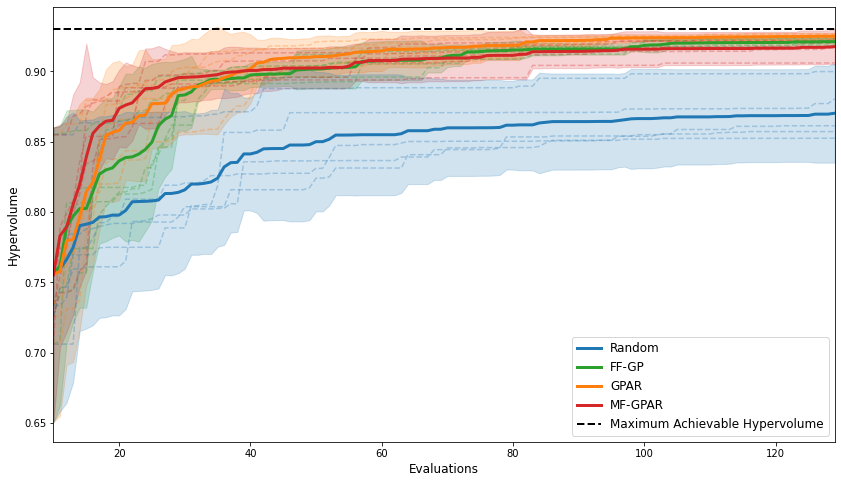

In [92]:
plot_bayesopt_experiment(*old_fft_summaries, kind="fft", save=False)

Saved figure!


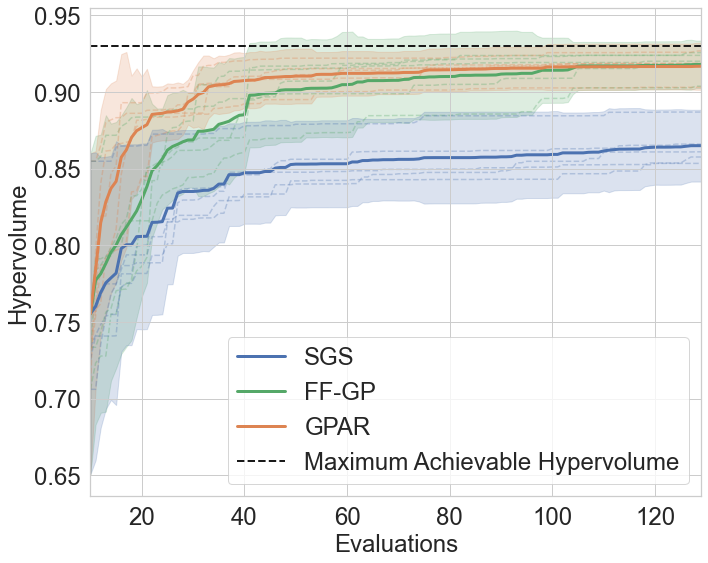

In [47]:
plot_bayesopt_experiment(*new_fft_summaries, kind="fft", save=True)

Figure wasn't saved.


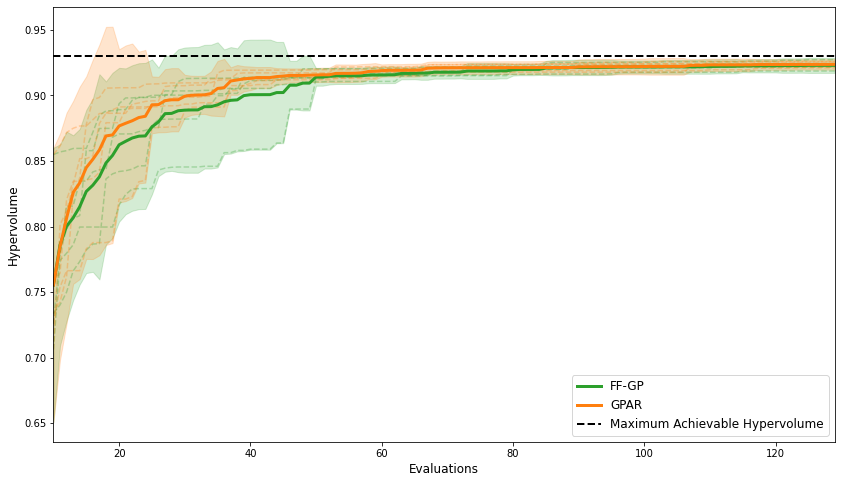

In [95]:
plot_bayesopt_experiment(*new_fft_input_trans_summaries, kind="fft", save=False)

Figure wasn't saved.


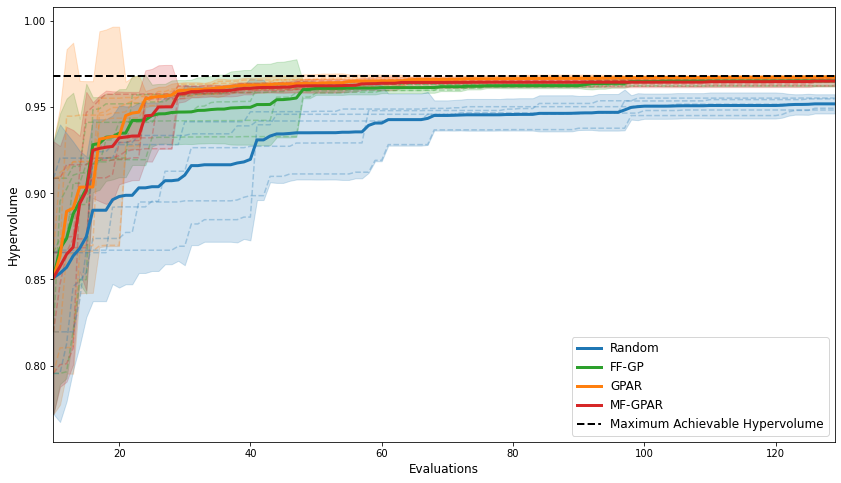

In [96]:
plot_bayesopt_experiment(*old_stencil3d_summaries, kind="stencil3d", save=False)

Saved figure!


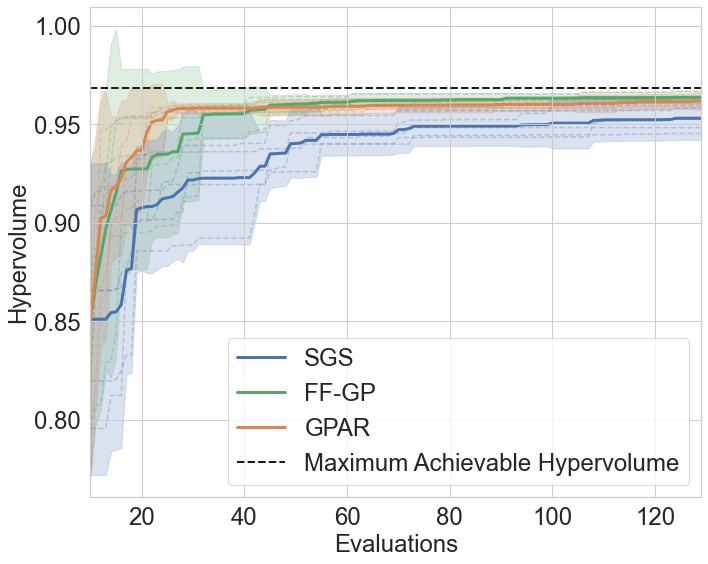

In [48]:
plot_bayesopt_experiment(*new_stencil3d_summaries, kind="stencil3d", save=True)

Figure wasn't saved.


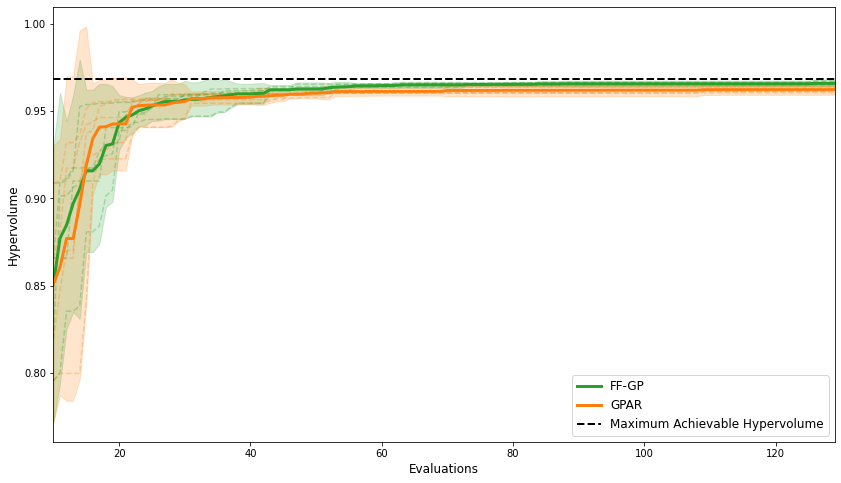

In [98]:
plot_bayesopt_experiment(*new_stencil3d_input_trans_summaries, kind="stencil3d", save=False)

Saved figure!


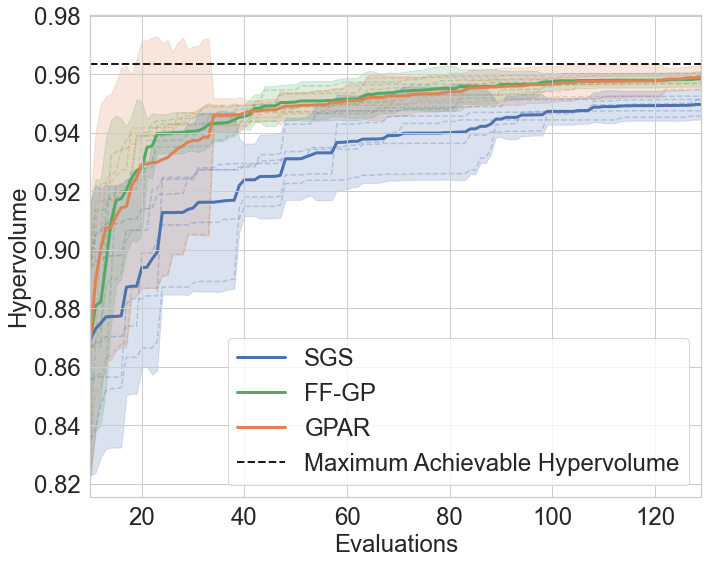

In [49]:
plot_bayesopt_experiment(*new_stencil3d_v2_summaries, kind="stencil3d_v2", save=True)

Saved figure!


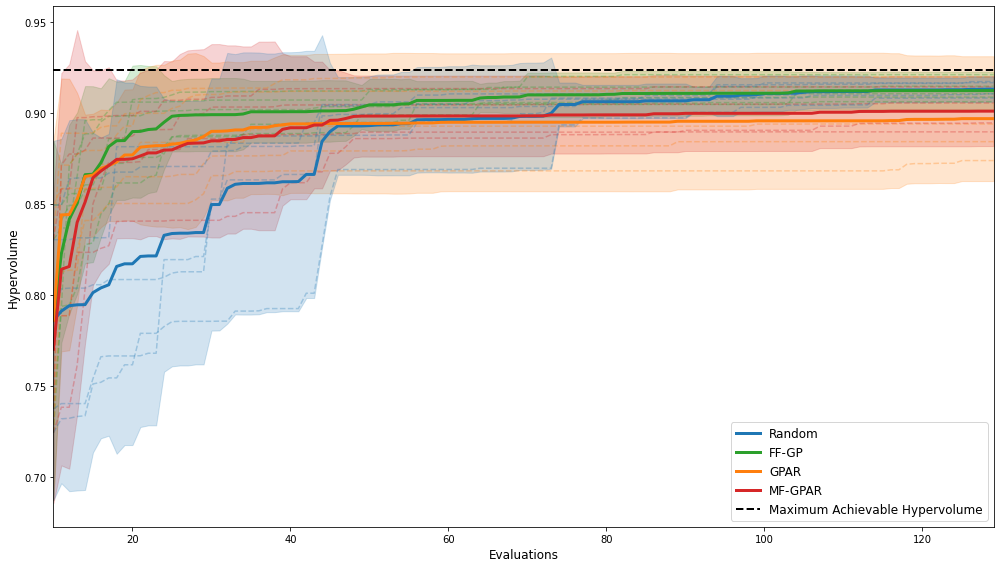

In [25]:
plot_bayesopt_experiment(*gemm_summaries, kind="gemm", save=True)

Saved figure!


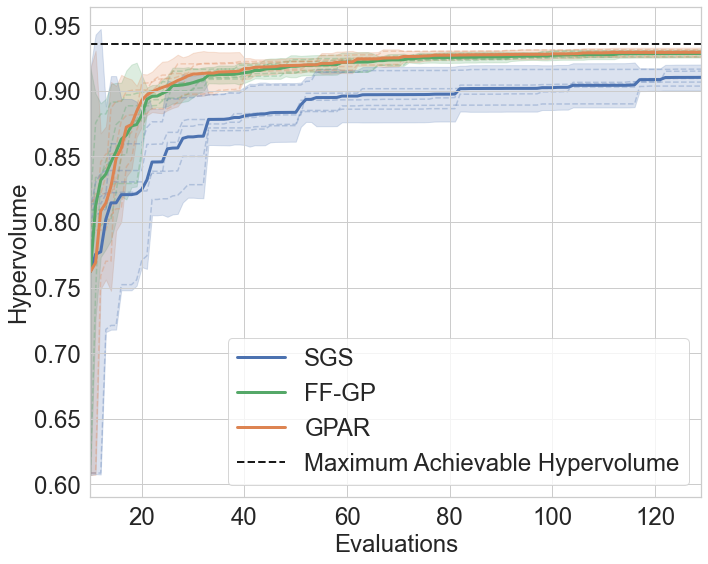

In [50]:
plot_bayesopt_experiment(*gemm_v2_summaries, kind="gemm_v2", save=True)

Saved figure!


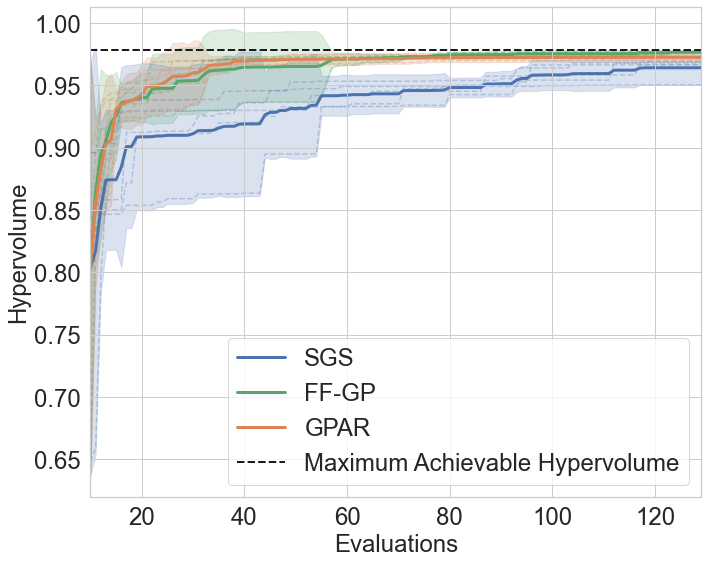

In [51]:
plot_bayesopt_experiment(*smaug_summaries, kind="smaug", save=True)

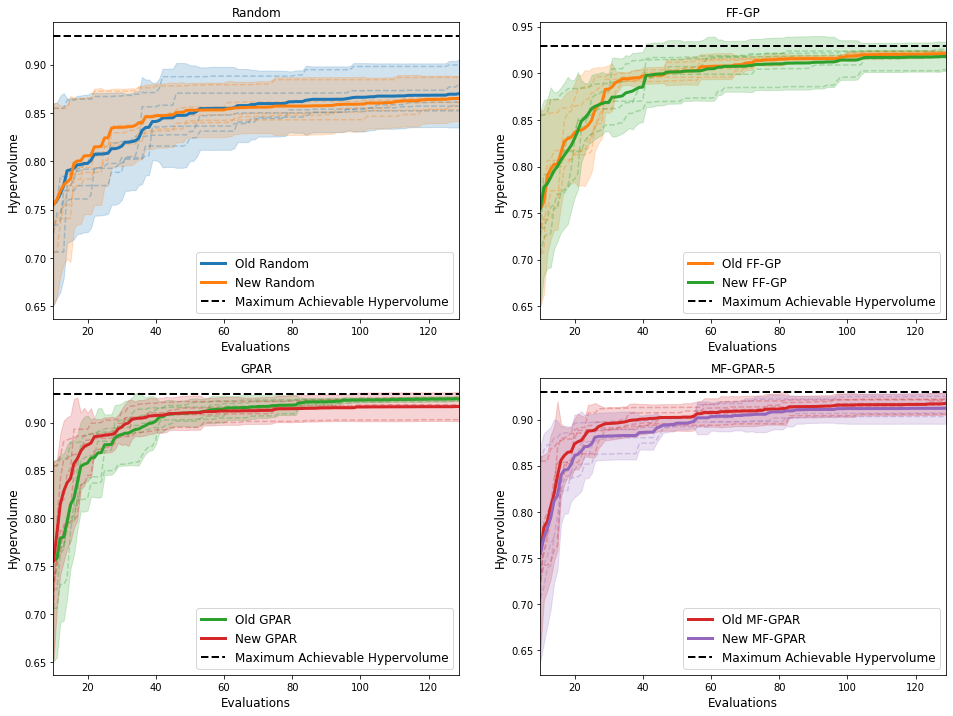

In [109]:
comparison_plot(*(old_fft_summaries + new_fft_summaries), kind="fft")

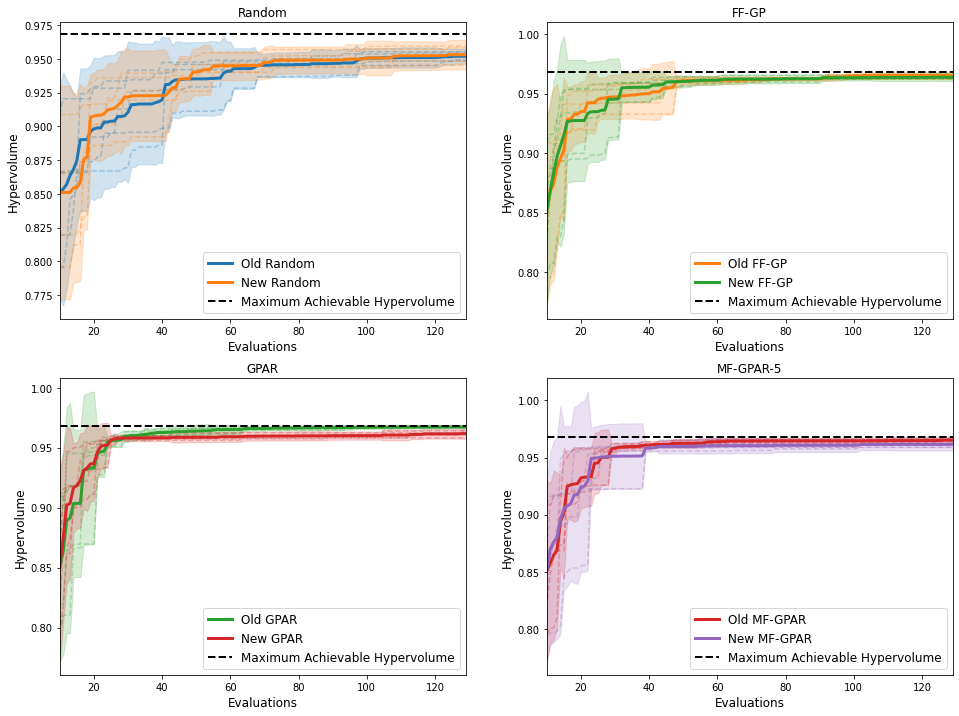

In [110]:
comparison_plot(*(old_stencil3d_summaries + new_stencil3d_summaries), kind="stencil3d")

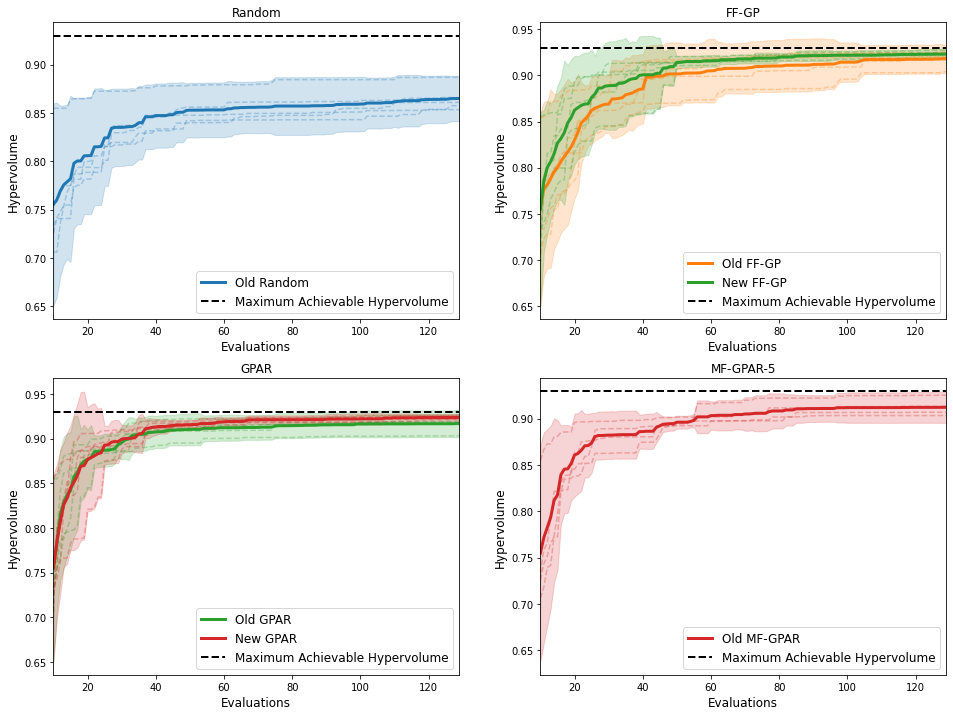

In [111]:
comparison_plot(*(new_fft_summaries + new_fft_input_trans_summaries), kind="fft")

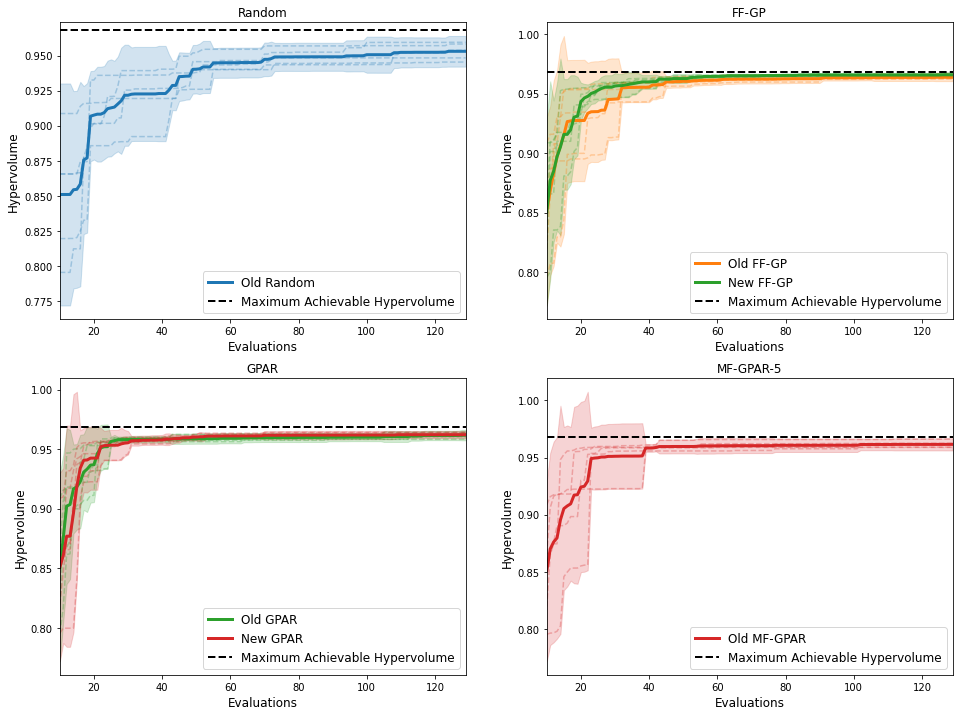

In [119]:
comparison_plot(*(new_stencil3d_summaries + new_stencil3d_input_trans_summaries), kind="stencil3d")

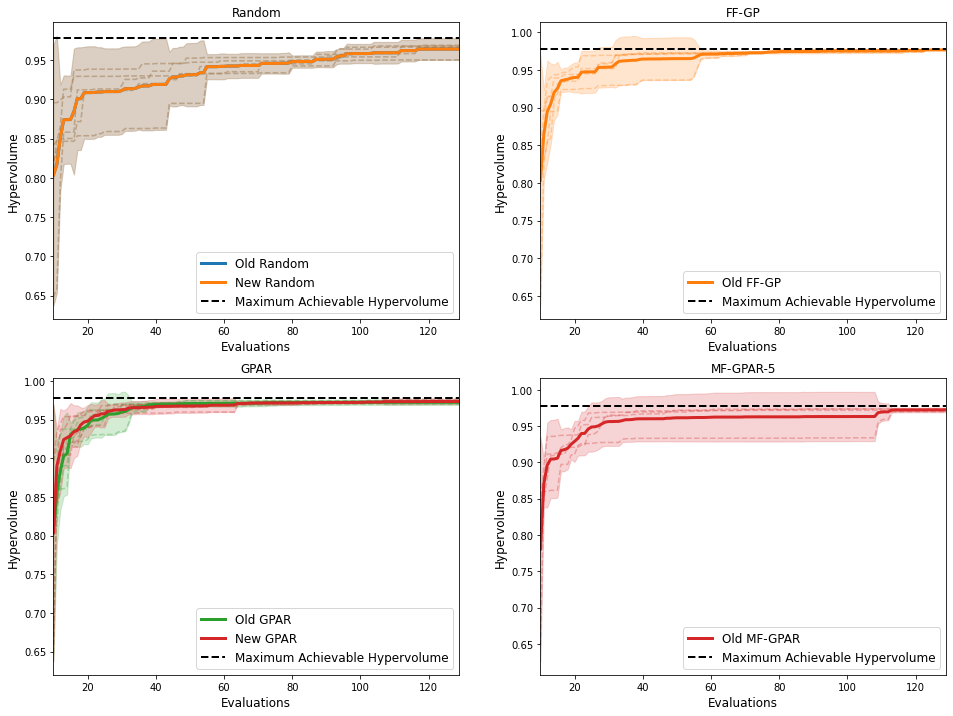

In [118]:
comparison_plot(*(smaug_summaries + new_smaug_summaries), kind="smaug")